### Integrated Lipolysis and Vesicle Growth
- Added 11/17/2022, LB and PM
- Updated 12/01/2022, LB and PM
    - Removed extraneous code
    - Resolved material balance issues
    - Introduced new variables to be included in sensitivity analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as ode
from collections import namedtuple

In [2]:
# Define summary tuples
# expt_summary tuple contains invariant parameters
expt_summary = namedtuple('expt_summary', ['V_soln', 'MWTG', 'dens_oil', 'enz_conc']) 

# Remaining four tuples contain other parameters, most of which are included in the sensitivity analysis, 
# separated by category 
digestion_constants = namedtuple('digestion_constants', ['alpha_MG', 'FA_frac'])
vesicle_constants = namedtuple('vesicle_constants', ['k1', 'k2', 'k3', 'k4', 'gamma', 'delta', 'epsilon'])
solubility_constants = namedtuple('solubility_constants', ['K_w', 'K_oil', 'K_mic', 'K_vs', 'K_vl']) 
initial_conditions = namedtuple('initial_conditions', ['D0', 'TG0', 'FA0', 'MG0', 'DG0'])

In [3]:
# Create a tuple with the format of "expt_summary" containing the experiment details
expt_conditions = expt_summary(V_soln = 16, MWTG = 885.43, dens_oil = 0.9, enz_conc = 0.00436)

In [4]:
def calc_N0(expt_summary, initial_conditions):
    """
    Calculate the initial number of oil droplets given experiment parameters
    Assumes the oil phase has a uniform droplet diameter D0
    Inputs: 
    expt_summary tuple
    initial_conditions tuple
    
    Outputs:
    Initial number of oil droplets
    """
    V_soln, MWTG, dens_oil = expt_summary[0:3]
    N0 = ( 6. * initial_conditions.TG0 * V_soln * MWTG * 1e-6 ) / \
         ( np.pi * dens_oil * np.power( initial_conditions.D0, 3) ) 
    return N0

In [5]:
def calc_oil_area(N0, mTG, expt_summary):
    """
    Calculate the total oil surface area given the initial number of oil droplets, TG concentration,
        TG properties, and solution volume
    Assumes that the number of oil droplets is conserved with time
    
    Inputs:
    N0 = scalar, initial number of oil droplets returned by calc_N0
    mTG = scalar, concentration of triglyceride [mM]
    expt_summary tuple
    
    Outputs:
    A_oil = scalar, estimated area of oil phase [cm^2]
    
    """
    V_soln, MWTG, dens_oil = expt_summary[0:3]
    
    # Clip mTG output to prevent negative values from entering area calucation
    mTG = np.clip(mTG, 0, None)
    
    A_oil = np.power( (N0 * np.pi), (1/3) ) * np.power( ( ( 6 * mTG * V_soln * MWTG * 1e-6) / dens_oil), (2/3)) 
    return A_oil

In [6]:
def langmuir_lipolysis(t, Y, expt_summary, digestion_constants, vesicle_constants, initial_conditions):
    """
    Calculates the differential change in molar concentration [mmol/L] for:
        Triglyceride (TG)
        Fatty Acid (FA)
        Monoglyceride (MG)
        Diglyceride (DG)
    
    Also calculates the differential change in number concentrations [L^-1 min^-1] for:
    
        Micelles (m)
        Pre-formed vesicles (s)
        Micelle intermediate (i)
        Grown vesicles (l)

    Combines these differential changes in 
    
    Inputs: t, time (not used explicitly in calculations, but required for ODE solver)
            Y, vector containing the ordered concentrations of all eight species
            expt_summary, digestion_constants, vesicle_constants, 
            initial_conditions = named tuples containing relevant constants
    Outputs: dY, vector containing the ordered differential changes in concentrations of all eight species
    """
    
    mTG, mFA, mMG, mDG, m, s, i, l = Y
    # mM                Number density (L^-1)   

    
    N0 = calc_N0(expt_summary, initial_conditions)
    A_oil = calc_oil_area(N0, mTG, expt_summary)
    
    
    # Calculate fractional expression of competitive Langmuir model
    theta = expt_summary.enz_conc / ( ( 1 + expt_summary.enz_conc + digestion_constants.alpha_MG * mMG ) )
    
    dmTG = - ( A_oil ) * theta                                  # mmol/L/min or mM/min    
    dmFA = - ( 1 + digestion_constants.FA_frac ) * dmTG         # mmol/L/min or mM/min
    dmMG = - digestion_constants.FA_frac * dmTG                 # mmol/L/min or mM/min
    dmDG = - ( 1 - digestion_constants.FA_frac ) * dmTG         # mmol/L/min or mM/min
       
    
    k1, k2, k3, k4, gamma, delta, epsilon = vesicle_constants
    
    
    dm = - k1 * epsilon * m * s - k2 * m + ( ( 6.022e20) / gamma ) * dmFA    # L^-1 min^-1
    ds = - k1 * epsilon * m * s - k3 * epsilon * i * s + k4 * delta * i      # L^-1 min^-1
    di = k2 * m - k3 * s * epsilon * i - k4 * delta * i                      # L^-1 min^-1
    dl = k1 * epsilon * m * s + k3 * s * epsilon * i                         # L^-1 min^-1
    
    dY = [dmTG, dmFA, dmMG, dmDG, dm, ds, di, dl]
    
    return dY

In [7]:
def find_Lang_solution(expt_summary, params, times = np.arange(0, 120.1, 0.1)):
    """
    Solves the Langmuir lipolysis system for a given set of experimental conditions using specified model coefficients
    expt_summary = named tuple
    params = tuple consisting of named tuples of types (digestion_constants, vesicle_constants, initial_conditions)
    times (optional) = times to evaluate the solution at, defaults to [0 min, 120 min] with 0.1 min spacing
    """
    
    # Unpack input parameter tuple
    digestion_constants, vesicle_constants, ics = params
    
    # Establish initial condition from experiment summary
    Y0 = np.array([ics.TG0, ics.FA0, ics.MG0, ics.DG0,
                   (ics.FA0 * ( ( 6.022e20 ) / vesicle_constants.gamma ) ), 0, 0, 0])
    
    atol_in = np.array([1e-6, 1e-6, 1e-6, 1e-6, 1, 1e-6, 1, 1])    # Absolute integration tolerance
    
    ode_soln = ode.solve_ivp(langmuir_lipolysis, t_span = [0,times[-1]], y0 = Y0, method = 'Radau', t_eval = times,  
                              atol = atol_in, args = [expt_summary, digestion_constants, vesicle_constants, ics])
    return ode_soln

### Example for testing ODE solution method with typical conditions

In [8]:
def plot_profiles(sol):
    """
    Generates a figure of a provided ODE solution consisting of TG and FA profiles
    """
    
    print(sol)

    print(sol.t.shape,sol.y.shape)

    plt.style.use('classic')

    plt.figure()
    legendCat = list()
    plt.plot(sol.t, sol.y[0,:])

    plt.title("TG profile")
    plt.xlabel("Time (min)")
    plt.ylabel("TG Concentration (mM)")
    plt.grid(visible = True)
    plt.show()


    plt.figure()
    legendCat = list()
    plt.plot(sol.t, sol.y[1,:])

    plt.title("FA profile")
    plt.xlabel("Time (min)")
    plt.ylabel("FA Concentration (mM)")
    plt.grid(visible = True)
    plt.show()
    
    plt.figure()
    legendCat = list()
    plt.plot(sol.t, sol.y[2,:])

    plt.title("MG profile")
    plt.xlabel("Time (min)")
    plt.ylabel("MG Concentration (mM)")
    plt.grid(visible = True)
    plt.show()
        
    plt.figure()
    legendCat = list()
    plt.plot(sol.t, sol.y[3,:])

    plt.title("DG profile")
    plt.xlabel("Time (min)")
    plt.ylabel("DG Concentration (mM)")
    plt.grid(visible = True)
    plt.show()
    
    plt.figure()
    legendCat = list()
    plt.plot(sol.t, sol.y[4,:])

    plt.title("Micelle concentration profile")
    plt.xlabel("Time (min)")
    plt.ylabel("Micelle Concentration (Count/L)")
    plt.grid(visible = True)
    plt.show()


    plt.figure()
    legendCat = list()
    plt.plot(sol.t, sol.y[5,:])

    plt.title("Pre-formed vesicle concentration profile")
    plt.xlabel("Time (min)")
    plt.ylabel("Pre-formed Vesicle Concentration (Count/L)")
    plt.grid(visible = True)
    plt.show()
    
    plt.figure()
    legendCat = list()
    plt.plot(sol.t, sol.y[6,:])

    plt.title("Intermediate concentration profile")
    plt.xlabel("Time (min)")
    plt.ylabel("Intermediate Concentration (Count/L)")
    plt.grid(visible = True)
    plt.show()
        
    plt.figure()
    legendCat = list()
    plt.plot(sol.t, sol.y[7,:])

    plt.title("Vesicle concentration profile")
    plt.xlabel("Time (min)")
    plt.ylabel("Vesicle Concentration (Count/L)")
    plt.grid(visible = True)
    plt.show()

In [9]:
# Example displaying underlying model predictions: Time evolution of TG, FA, MG, DG, m, s, i, l concentrations

# Setting values for each input tuple
digestion_constants_guess = digestion_constants(alpha_MG = 20, FA_frac = 0.60)
vesicle_constants_guess = vesicle_constants(k1 = 96, k2 = 4.8, k3 = 0.6, k4 = 2, 
                                            gamma = 50, delta = 100, epsilon = 100)
initial_conditions_guess = initial_conditions(D0 = 4437e-7, TG0 = 20, FA0 = 0, MG0 = 0, DG0 = 0)


In [10]:
# Input the chosen parameters here and compute the solution
opt_lang_sol = find_Lang_solution(expt_conditions, (digestion_constants_guess,
                                  vesicle_constants_guess, initial_conditions_guess), 
                                  times = np.arange(0, 120.1, 0.1))

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1580
     njev: 86
      nlu: 342
      sol: None
   status: 0
  success: True
        t: array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.198e+02, 1.199e+02,
       1.200e+02])
 t_events: None
        y: array([[2.00000000e+01, 1.95239695e+01, 1.92985208e+01, ...,
        5.21082556e+00, 5.20658485e+00, 5.20234765e+00],
       [0.00000000e+00, 7.61648768e-01, 1.12236668e+00, ...,
        2.36626791e+01, 2.36694642e+01, 2.36762438e+01],
       [0.00000000e+00, 2.85618288e-01, 4.20887504e-01, ...,
        8.87350466e+00, 8.87604909e+00, 8.87859141e+00],
       ...,
       [0.00000000e+00, 4.98473659e-04, 5.04376780e-04, ...,
        4.99983739e-04, 4.99944766e-04, 4.99884254e-04],
       [0.00000000e+00, 1.27163789e+17, 1.14893022e+17, ...,
        2.04566069e+15, 2.04396665e+15, 2.04227420e+15],
       [0.00000000e+00, 1.86577686e+18, 4.32899234e+18, ...,
        1.42453008e+20, 1.42493904e+20, 1

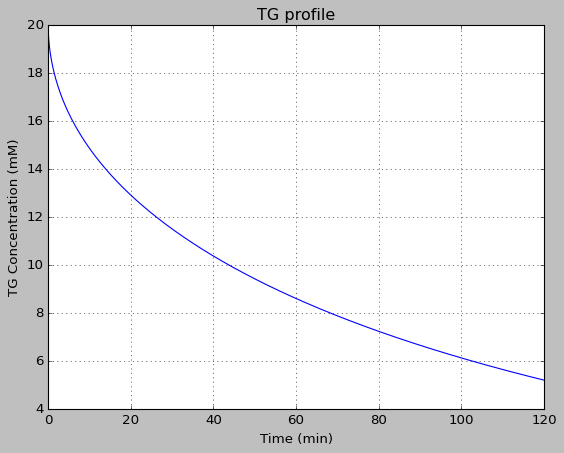

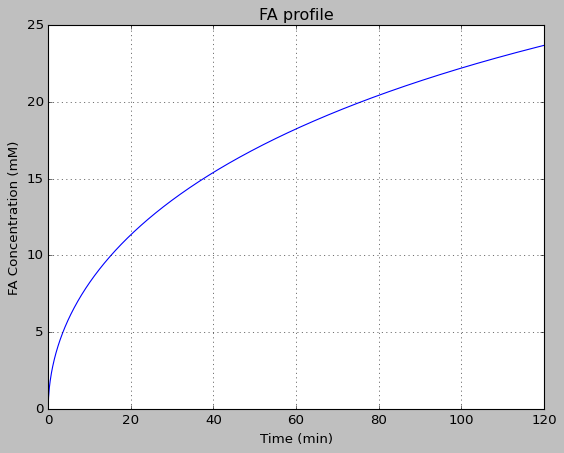

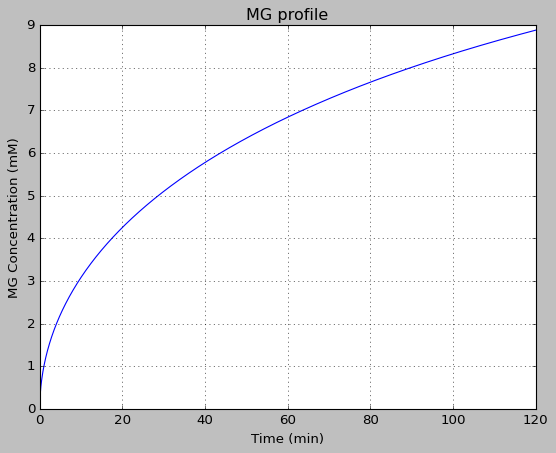

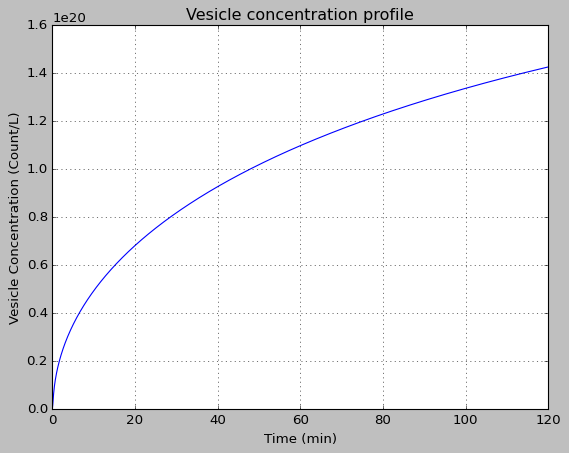

In [11]:
# Plot the concentration profiles
plot_profiles(opt_lang_sol)

### Application of Results: Functions for Calculating Solubility

In [12]:
def oil_volume(mTG, expt_summary):
    """
    Calculates the volume of the oil phase according to the instantaneous molar concentration of TG 
    and expt_summary parameters
    """
    V_oil = ( expt_summary.V_soln * mTG * expt_summary.MWTG * 1e-6 ) / expt_summary.dens_oil
    
    return V_oil

In [13]:
def calc_solubility(Y_slice, *args):
    """
    Calculates the overall solubility of drug given the solution composition specified by the Y_slice vector
    Assumes each phase contributes linearly to the overall solubility
    
    Y_slice = [mTG, mFA, mMG, mDG, m, s, i, l], slice of solution array containing instantaneous 
    concentrations of all species
    
    *args = expt_summary, vk, sc
    [expt_conditions, vesicle_constants_guess, solubility_constants_guess]
    
    """
    expt_sum, vk, sc = args
    
    V_oil = oil_volume(Y_slice[0], expt_sum)
    
    solubility = (sc.K_w * expt_sum.V_soln 
    + sc.K_oil * V_oil 
    + (sc.K_mic * vk.gamma * Y_slice[4]
    + sc.K_vs * vk.delta * Y_slice[5]
    + sc.K_vl * vk.epsilon * Y_slice[7]) * expt_sum.V_soln) / (expt_sum.V_soln + V_oil) 
    
    return solubility

### Sobol Sensitivity Analysis
- Added 11/18/2022, LB and PM
- Borrowed code snippets from example at https://salib.readthedocs.io/en/latest/basics.html

In [14]:
from SALib.sample import sobol as sbl
from SALib.analyze import sobol

In [15]:
problem = {
    'num_vars': 17,
    'names': ['alpha_MG', 'FA_frac', 'k1', 'k2', 'k3', 'k4', 'gamma', 'delta', 'epsilon', 
              'K_w', 'K_oil', 'K_mic', 'K_vs', 'K_vl', 'D0', 'TG0', 'FA0'],
    'bounds': [[0.1, 100],
               [0, 1],
               [10, 500],
               [0.1, 100],
               [0.01, 100],
               [0.1, 10],
               [50, 500],
               [1, 10],
               [10, 100],
               [0.01, 0.1],
               [0.1, 1],
               [0.1e-20, 1e-20],
               [1e-20, 5e-20],
               [5e-20, 10e-20],
               [1e-7, 1e-5],
               [5, 80],
               [0, 20]
              ]
}

In [16]:
param_values = sbl.sample(problem, 1024)

In [17]:
param_values.shape

(36864, 17)

In [18]:
# Function to calculate solubility given parameter values and time
def model_output_parameters(expt_summary, X, times = np.arange(1, 121, 1)):
    def output_array(X):
        
        digestion_constants_in = digestion_constants(alpha_MG = X[0], FA_frac = X[1]) 
        vesicle_constants_in = vesicle_constants(k1 = X[2], k2 = X[3], k3 = X[4], k4 = X[5], 
                                                 gamma = X[6], delta = X[7], epsilon = X[8])
        sol_constants_in = solubility_constants(K_w = X[9], K_oil = X[10], K_mic = X[11], 
                                                K_vs = X[12], K_vl = X[13])
        ics_in = initial_conditions(D0 = X[14], TG0 = X[15], FA0 = X[16], MG0 = 0, DG0 = 0) 
        
        Lang_soln = find_Lang_solution(expt_summary, 
                                       (digestion_constants_in, vesicle_constants_in, ics_in), times = times)
        
        # Current solution for relatively uncommon bug, in which no change occurs in the Y solution vector
        # Bug results in "Required step size is less than spacing between numbers" error message from solve_ivp
        # The solution is only computed for part of t_eval
        # Fix: Fill the remaining entries of solution array with the last nonzero values 
        # (assuming no further changes)
        
        # Check if the ODE solver generated an empty array
        if not type(Lang_soln.y) == np.ndarray:
            # Set the solution equal to the initial condition (to be extended over entire solution interval next)
            Lang_soln.y = np.array([[ics_in.TG0, ics_in.TG0], [ics_in.FA0, ics_in.FA0], 
                                    [ics_in.MG0, ics_in.MG0], [ics_in.DG0, ics_in.DG0], 
                                    [(ics_in.FA0 * ( ( 6.022e20 ) / vesicle_constants_in.gamma ) ),
                                    (ics_in.FA0 * ( ( 6.022e20 ) / vesicle_constants_in.gamma ) )], 
                                    [0, 0], [0, 0], [0, 0]])
            print(Lang_soln.y)
            
        if Lang_soln.y.size != 120:
            
            # Prepare last solution evaluation to populate the solution extension array
            last_soln_point = np.reshape(Lang_soln.y[:, -1], (8, 1))
            
            # Create array to extend Lang_soln.y array to last time point
            Lang_soln_ext = np.full((8, (len(times) - len(Lang_soln.y[0]))), last_soln_point)
            
            # Append the current, unfinished solution with the solution extension
            Lang_soln.y = np.append(Lang_soln.y, Lang_soln_ext, axis = 1)
        
        
        
        # Calculate the solubilities expected at each time point's "composition"
        solubilities = np.apply_along_axis(calc_solubility, 0, Lang_soln.y, 
                            expt_summary, vesicle_constants_in, sol_constants_in)
        
        # Reshape the solubilities array to be appended to the ODE solution array 
        solubilities = np.reshape(solubilities, (1, len(times)))
        
        # Combine the ODE solution and solubilities array to form the function output
        outputs = np.append(Lang_soln.y, solubilities, axis = 0)

        return outputs
        
    return output_array(X)

In [19]:
# Define time points
time_points = np.arange(1, 121, 1)

In [20]:
# Array for storing output
sobol_output = np.zeros([param_values.shape[0], 9, len(time_points)])

# Loop through the generated samples using enumerate
for i, X in enumerate(param_values):
    model_outputs = model_output_parameters(expt_conditions, X)
    sobol_output[i] = model_outputs

ValueError: cannot reshape array of size 15 into shape (1,120)

In [21]:
# Isolate the dissolution profiles from each sample in the "disso_profiles" variable
disso_profiles = [sobol_output[i, -1] for i in range(0, len(sobol_output))]

In [22]:
# Store analysis results in sobol_indices
# Line is based on code from the source above
sobol_indices = [sobol.analyze(problem, profile) for profile in np.transpose(disso_profiles)]

In [23]:
# Collect first-order Sobol indices in the "S1s" variable 
S1s = np.array([s['S1'] for s in sobol_indices])

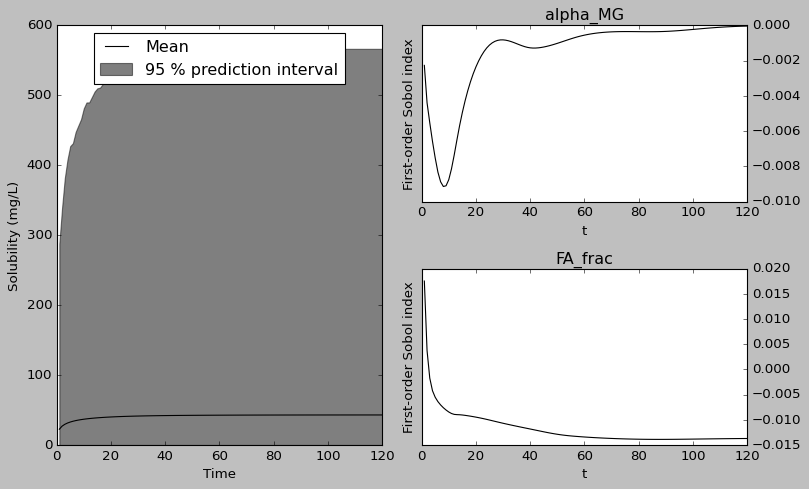

In [24]:
# Note: Code modified from code available on the SALib documentation website

fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

# Customize placement of the subplots (specify "row, then column")
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

# Loop through plots ax1 and ax2 to generate curves on right hand side
for i, ax in enumerate([ax1, ax2]):
    ax.plot(time_points, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='black')
    ax.set_xlabel("t")
    ax.set_ylabel("First-order Sobol index")

    ax.set_title(problem["names"][i])

    ax.yaxis.tick_right()

    

# Populate graph on left hand side
ax0.plot(time_points, np.mean(disso_profiles, axis=0), label="Mean", color='black')

# in percent
prediction_interval = 95

ax0.fill_between(time_points,
                 np.percentile(disso_profiles, 50 - prediction_interval/2., axis=0),
                 np.percentile(disso_profiles, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='black',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("Time")
ax0.set_ylabel("Solubility (mg/L)")
ax0.legend(loc='upper center')._legend_box.align = "left"

plt.show()

In [25]:
# Plot Results for vesicle growth parameters
# Code modified from example on SALib documentation website
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(3, 3)

# Customize placement of the subplots (specify "row, then column")
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])

subplots = [ax0, ax1, ax2, ax3, ax4, ax5, ax6]

# Loop through plots ax0 to ax6 to generate curves
for i, ax in enumerate(subplots):
    ax.plot(time_points, S1s[:, (i + 2 )],
            color='black')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("First-order Sobol index")
    ax.set_title(problem["names"][(i + 2)])
    
    ax.yaxis.tick_right()

plt.show()

In [26]:
# Plot Results for solubility parameters
# Code modified from example on SALib documentation website
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 3)

# Customize placement of the subplots (specify "row, then column")
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

subplots = [ax0, ax1, ax2, ax3, ax4]

# Loop through plots ax0 to ax4 to generate curves
for i, ax in enumerate(subplots):
    ax.plot(time_points, S1s[:, (i + 9)],
            color='black')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("First-order Sobol index")
    ax.set_title(problem["names"][(i + 9)])
    
    ax.yaxis.tick_right()

plt.show()

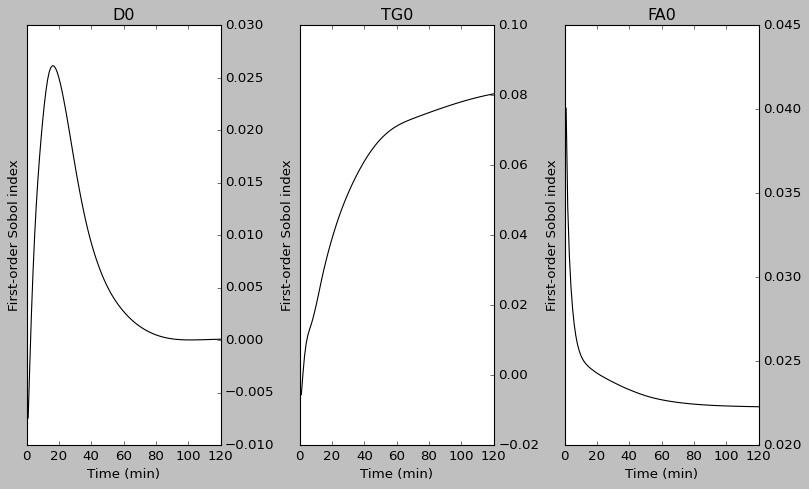

In [27]:
# Plot Results for solubility parameters
# Code modified from example on SALib documentation website
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

# Customize placement of the subplots (specify "row, then column")
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

subplots = [ax0, ax1, ax2]

# Loop through plots ax1 to ax7 to generate curves on right hand side
for i, ax in enumerate(subplots):
    ax.plot(time_points, S1s[:, (i + 14)],
            color='black')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("First-order Sobol index")
    ax.set_title(problem["names"][(i + 14)])
    
    ax.yaxis.tick_right()

plt.show()

### Higher order effects

In [28]:
# Collect total-order and second-order Sobol indices in the "STs" and "S2s" variables 
STs = np.array([s['ST'] for s in sobol_indices])
S2s = np.array([s['S2'] for s in sobol_indices])

In [29]:
# Note: Code modified from code available on the SALib documentation website

fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 2)

# Customize placement of the subplots (specify "row, then column")
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Loop through plots ax1 and ax2 to generate curves on right hand side
for i, ax in enumerate([ax1, ax2]):
    ax.plot(time_points, STs[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='black')
    ax.set_xlabel("t")
    ax.set_ylabel("Total-order Sobol index")

    ax.set_title(problem["names"][i])

    ax.yaxis.tick_right()

plt.show()

In [30]:
# Plot Results for vesicle growth parameters
# Code modified from example on SALib documentation website
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(3, 3)

# Customize placement of the subplots (specify "row, then column")
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])

subplots = [ax0, ax1, ax2, ax3, ax4, ax5, ax6]

# Loop through plots ax0 to ax6 to generate curves
for i, ax in enumerate(subplots):
    ax.plot(time_points, STs[:, (i + 2 )],
            color='black')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Total-order Sobol index")
    ax.set_title(problem["names"][(i + 2)])
    
    ax.yaxis.tick_right()

plt.show()

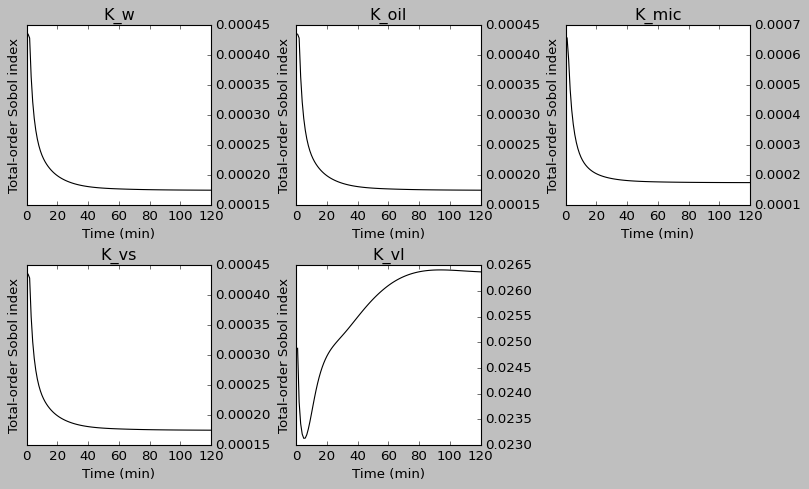

In [31]:
# Plot Results for solubility parameters
# Code modified from example on SALib documentation website
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(2, 3)

# Customize placement of the subplots (specify "row, then column")
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

subplots = [ax0, ax1, ax2, ax3, ax4]

# Loop through plots ax0 to ax4 to generate curves
for i, ax in enumerate(subplots):
    ax.plot(time_points, STs[:, (i + 9)],
            color='black')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Total-order Sobol index")
    ax.set_title(problem["names"][(i + 9)])
    
    ax.yaxis.tick_right()

plt.show()

In [32]:
# Plot Results for solubility parameters
# Code modified from example on SALib documentation website
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

# Customize placement of the subplots (specify "row, then column")
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

subplots = [ax0, ax1, ax2]

# Loop through plots ax1 to ax7 to generate curves on right hand side
for i, ax in enumerate(subplots):
    ax.plot(time_points, STs[:, (i + 14)],
            color='black')
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Total-order Sobol index")
    ax.set_title(problem["names"][(i + 14)])
    
    ax.yaxis.tick_right()

plt.show()